In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from outlier_detection import plot_distribution

In [2]:
df = pd.read_csv('../development.csv')

df.head(2)

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,...,-0.160714,-0.50,-0.071429,0.0,0.0,0.5,0.0,2900,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,...,-0.157500,-0.25,-0.100000,0.0,0.0,0.5,0.0,1300,tech,thursday


In [3]:
# url,id  and time delta are not predictive column --> drop them
df = df.drop(['url','timedelta','id'], axis=1)


# fill missing values with the mean of thier column 
columns_to_fill = ['num_imgs', 'num_videos', 'num_keywords']

# Fill missing values with the mean
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())






# weekdays --> ordinal scaling 

weekday_mapping = {
    'monday': 0,
    'tuesday': 1,
    'wednesday': 2,
    'thursday': 3,
    'friday': 4,
    'saturday': 5,
    'sunday': 6
}

# Replace the values in 'weekday' column with encoded values
df['weekday'] = df['weekday'].replace(weekday_mapping)



# data_channel --> it takes only 5 values, so it will be encoded with one hot encoding

one_hot_encoded = pd.get_dummies(df['data_channel'])

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)
df  = df.drop('data_channel', axis=1)




In [4]:
df['n_tokens_content'].value_counts()

# a lot of values are 0 --> remove them

df = df[df['n_tokens_content'] != 0]



#drop this columns
df = df.drop(['n_non_stop_unique_tokens','n_unique_tokens','n_non_stop_words'], axis=1)

In [5]:
# self_reference

df['self_reference'] = df['self_reference_avg_sharess'] * 0.6 + df['self_reference_max_shares']*0.2 + df['self_reference_min_shares']*0.2

df = df.drop(['self_reference_avg_sharess','self_reference_max_shares','self_reference_min_shares'],axis=1)


In [6]:
# rate_positive/ rate_negative

# look at the correlation btw these two variables with share
print('Correlation btw rate_positive_words and rate_negative_words ',df[['rate_positive_words', 'rate_negative_words', 'shares']].corr())

# rate_positive_words AND rate_negative_words are equally correlated with shares --> delete rate_negative_words
df = df.drop(['rate_negative_words'],axis=1)


Correlation btw rate_positive_words and rate_negative_words                       rate_positive_words  rate_negative_words    shares
rate_positive_words             1.000000            -0.997122 -0.004482
rate_negative_words            -0.997122             1.000000  0.004628
shares                         -0.004482             0.004628  1.000000


In [5]:
df.head()

,n_tokens_title,n_tokens_content,n_non_stop_words,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,abs_title_subjectivity,abs_title_sentiment_polarity,shares,weekday,bus,entertainment,lifestyle,socmed,tech,world
0,12.0,1015.0,1.0,10.0,6.0,33.000000,1.0000,4.656158,4.000000,-1.0,...,0.5,0.00,2900,1,1,0,0,0,0,0
1,9.0,503.0,1.0,9.0,0.0,4.533899,1.0000,4.576541,10.000000,4.0,...,0.5,0.00,1300,3,0,0,0,0,1,0
2,9.0,232.0,1.0,12.0,3.0,4.000000,1.0000,4.935345,6.000000,4.0,...,0.5,0.00,17700,2,0,0,1,0,0,0
3,12.0,171.0,1.0,9.0,5.0,0.000000,1.2591,4.970760,6.000000,-1.0,...,0.1,0.25,1500,2,1,0,0,0,0,0
4,11.0,286.0,1.0,5.0,2.0,4.533899,0.0000,5.006993,7.220538,217.0,...,0.3,0.10,1400,3,0,0,0,0,1,0


In [7]:
# normalize other features 


def normalize_features(df):
    """
    This function normalizes features.
    Since more values are 0, use a zero-robust normalization technique --> log1p transformation
    For features without zero values, apply the normal log
    """
    normalize_df = df.copy()
    columns_to_exclude = ['shares', 'bus','entertainment','lifestyle','socmed','tech','world']
    df_excluded = normalize_df.drop(columns=columns_to_exclude)
    for column in df_excluded.columns:
        if normalize_df[column].dtype in [np.float64, np.int64]:
            if (normalize_df[column] != 0).all():
                normalize_df[column] = np.log(normalize_df[column])
    normalize_df = pd.concat([df_excluded, df[columns_to_exclude]], axis=1)
    return normalize_df




df_normalized = normalize_features(df)

In [7]:
df_normalized.head()

,n_tokens_title,n_tokens_content,n_non_stop_words,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,abs_title_subjectivity,abs_title_sentiment_polarity,weekday,shares,bus,entertainment,lifestyle,socmed,tech,world
0,12.0,1015.0,1.0,10.0,6.0,33.000000,1.0000,4.656158,4.000000,-1.0,...,0.5,0.00,1,2900,1,0,0,0,0,0
1,9.0,503.0,1.0,9.0,0.0,4.533899,1.0000,4.576541,10.000000,4.0,...,0.5,0.00,3,1300,0,0,0,0,1,0
2,9.0,232.0,1.0,12.0,3.0,4.000000,1.0000,4.935345,6.000000,4.0,...,0.5,0.00,2,17700,0,0,1,0,0,0
3,12.0,171.0,1.0,9.0,5.0,0.000000,1.2591,4.970760,6.000000,-1.0,...,0.1,0.25,2,1500,1,0,0,0,0,0
4,11.0,286.0,1.0,5.0,2.0,4.533899,0.0000,5.006993,7.220538,217.0,...,0.3,0.10,3,1400,0,0,0,0,1,0


# Holdout

In [8]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,StackingRegressor,BaggingRegressor
from sklearn.model_selection import train_test_split

X = np.array(df_normalized.drop(['shares'], axis=1))
y = df_normalized['shares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GradientBoostingRegressor

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

def gradient_boosting_regressor(n_components=5):
    #without PCA
    grad_bost_regr = GradientBoostingRegressor()
    grad_bost_regr.fit(X_train,y_train)
    y_pred = grad_bost_regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'GradientBoostingRegressor without PCA')
    print(f'rmse : {rmse}')
    print()
    print()
    print()
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    # Transform the test data using the trained PCA model
    X_test_pca = pca.transform(X_test)
    regr_pca = GradientBoostingRegressor()
    regr_pca.fit(X_train_pca,y_train)
    y_pred_pca = regr_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    print(f'GradientBoostingRegressor with PCA')
    print(f'rmse_pca : {rmse_pca}')

gradient_boosting_regressor(n_components=10)

GradientBoostingRegressor without PCA
rmse : 11449.625234061516



GradientBoostingRegressor with PCA
rmse_pca : 9895.820214718891


# AdaBoostRegressor

In [10]:
def ada_boost_regressor(n_components=5):
    #without PCA
    ada_bost_regr = AdaBoostRegressor()
    ada_bost_regr.fit(X_train,y_train)
    y_pred = ada_bost_regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'AdaBoostRegressor without PCA')
    print(f'rmse : {rmse}')
    print()
    print()
    print()
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    # Transform the test data using the trained PCA model
    X_test_pca = pca.transform(X_test)
    regr_pca = AdaBoostRegressor()
    regr_pca.fit(X_train_pca,y_train)
    y_pred_pca = regr_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    print(f'AdaBoostRegressor with PCA')
    print(f'rmse_pca : {rmse_pca}')

ada_boost_regressor()

AdaBoostRegressor without PCA
rmse : 24308.569046662935



AdaBoostRegressor with PCA
rmse_pca : 20382.37253793133


# BaggingRegressor

In [11]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression


def bagging_regressor(n_components=5):
    # Without PCA
    base_regressor = DecisionTreeRegressor()
    bagging_model = BaggingRegressor(base_estimator=base_regressor, n_estimators=10, random_state=42)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'BaggingRegressor without PCA')
    print(f'RMSE: {rmse}')
    print()
    print()
    print()

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    # Transform the test data using the trained PCA model
    X_test_pca = pca.transform(X_test)
    
    base_regressor_pca = DecisionTreeRegressor()
    bagging_model_pca = BaggingRegressor(base_estimator=base_regressor_pca, n_estimators=10, random_state=42)
    bagging_model_pca.fit(X_train_pca, y_train)  # Fit with transformed training data
    y_pred_pca = bagging_model_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    print(f'BaggingRegressor with PCA')
    print(f'RMSE (with PCA): {rmse_pca}')

bagging_regressor()


BaggingRegressor without PCA
RMSE: 12554.451845437607



BaggingRegressor with PCA
RMSE (with PCA): 11200.780498660552


# Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(n_components=5):
    # Without PCA
    base_regressor = RandomForestRegressor(n_estimators=10, random_state=42)
    base_regressor.fit(X_train, y_train)
    y_pred = base_regressor.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Random Forest Regressor without PCA')
    print('RMSE:', rmse)
    print()

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    base_regressor_pca = RandomForestRegressor(n_estimators=10, random_state=42)
    base_regressor_pca.fit(X_train_pca, y_train)
    y_pred_pca = base_regressor_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    rmse_pca = np.sqrt(mse_pca)
    print('Random Forest Regressor with PCA')
    print('RMSE (with PCA):', rmse_pca)


random_forest_regressor(10)


Random Forest Regressor without PCA
RMSE: 12006.286301659355

Random Forest Regressor with PCA
RMSE (with PCA): 10579.721944992254


GradientBoostingRegressor without PCA
rmse : 9678.918486807326
GradientBoostingRegressor with PCA


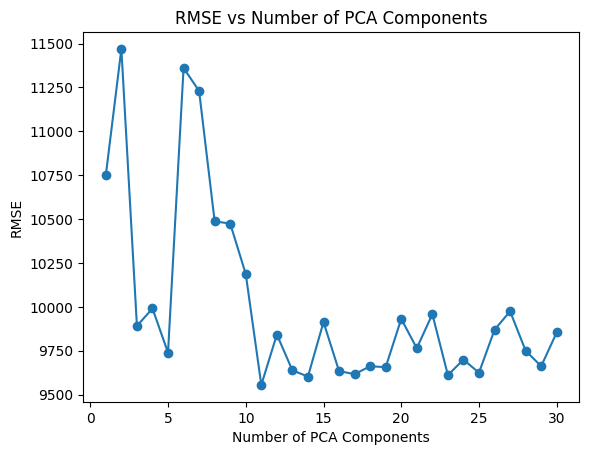

{1: 10750.21169482188,
 2: 11469.610240584381,
 3: 9891.570330280221,
 4: 9990.750354336691,
 5: 9739.145376316126,
 6: 11361.380766619686,
 7: 11229.629813862755,
 8: 10487.13644419128,
 9: 10474.613284691468,
 10: 10186.882292140832,
 11: 9555.342424312119,
 12: 9842.403067920974,
 13: 9638.095683117128,
 14: 9603.168671963025,
 15: 9913.305941993254,
 16: 9634.263507577052,
 17: 9616.64434784573,
 18: 9661.734531771288,
 19: 9656.564518744513,
 20: 9931.47517869107,
 21: 9764.236133101016,
 22: 9958.694468386133,
 23: 9611.269719308435,
 24: 9699.417529201437,
 25: 9624.644715534172,
 26: 9869.440938510881,
 27: 9975.0228596536,
 28: 9750.207709068698,
 29: 9661.954917420886,
 30: 9854.695471138137}

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


def plot_rmse_pca(rmse_dict):
    keys = list(rmse_dict.keys())
    values = list(rmse_dict.values())
    
    plt.plot(keys, values, marker='o')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of PCA Components')
    plt.show()


def gradient_boosting_regressor():
    #without PCA
    grad_bost_regr = GradientBoostingRegressor()
    grad_bost_regr.fit(X_train,y_train)
    y_pred = grad_bost_regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'GradientBoostingRegressor without PCA')
    print(f'rmse : {rmse}')
    #with PCA
    print(f'GradientBoostingRegressor with PCA')
    n_components = list(range(1,31))
    rmse_dict = {}
    for component in n_components:
        pca = PCA(n_components=component)
        X_train_pca = pca.fit_transform(X_train)
        # Transform the test data using the trained PCA model
        X_test_pca = pca.transform(X_test)
        regr_pca = GradientBoostingRegressor()
        regr_pca.fit(X_train_pca,y_train)
        y_pred_pca = regr_pca.predict(X_test_pca)
        mse_pca = mean_squared_error(y_test, y_pred_pca)
        rmse_pca = np.sqrt(mse_pca)
        rmse_dict[component] = rmse_pca
    plot_rmse_pca(rmse_dict)
    return rmse_dict
        
    
    
gradient_boosting_regressor()

